In [15]:
import torch
import torch.nn as nn
from torchvision import models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from pathlib import Path
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset


In [11]:
dataset_dir = Path("C:/Users/ricks/Downloads/Data/Data/classification_dataset/images")
labels_file = Path("C:/Users/ricks/Downloads/Data/Data/classification_dataset/labels.txt")

# Read the text file (filename label)
df = pd.read_csv(labels_file, sep=" ", header=None, names=["filename", "label"])

# Add full path column
df["path"] = df["filename"].apply(lambda x: dataset_dir / x)


label_map = {
    "crab": 0,
    "Eel": 1,
    "flatfish": 2,
    "roundfish": 3,
    "Scallop": 4,
    "skate": 5,
    "whelk": 6
}


df['label_id'] = df['label'].map(label_map)


train_val_df, test_df = train_test_split(df, test_size=0.1, stratify=df["label_id"], random_state=42)

train_df, val_df = train_test_split(train_val_df, test_size=0.2, stratify=train_val_df["label_id"], random_state=42)



In [12]:
class BenthicDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop = True)
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        row = self.df.iloc[idx]
        image = Image.open(row['path'])
        label = row['label_id']
        image = self.transform(image)
        return image, label

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recreate the model architecture exactly
weights = models.ResNet50_Weights.DEFAULT  


test_transforms = weights.transforms()


test_dataset = BenthicDataset(test_df, test_transforms)


test_loader = DataLoader(test_dataset, batch_size=32)

model = models.resnet50(weights=weights)

num_fts = model.fc.in_features
model.fc = nn.Linear(num_fts, 7)

model = model.to(device)

# Load the checkpoint
checkpoint = torch.load("best_model.pth", map_location=device)

# Load model weights
model.load_state_dict(checkpoint['model_state_dict'])

# Optional: load optimizer state if you want to resume training
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Set model to evaluation mode
model.eval()

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
# Evaluate on data
val_acc = checkpoint['val_acc']
print(f"Loaded model from epoch {checkpoint['epoch']} with val acc: {val_acc:.4f}")


Loaded model from epoch 8 with val acc: 0.8698


C:\Users\ricks\AppData\Local\Temp\ipykernel_25924\139052301.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("best_model.pth", map_location=devic

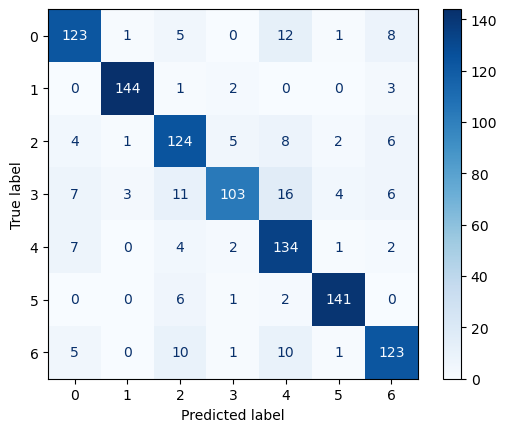

test accuracy: 0.8495238095238096


In [19]:
all_labels = []
all_preds = []
running_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:  # replace with validation/test loader
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        loss = criterion(outputs, labels)
        running_loss += loss.item() * images.size(0)
        _,preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(preds.cpu().numpy())   # move to CPU and collect
        all_labels.extend(labels.cpu().numpy())
    test_loss = running_loss/total
    test_acc = correct/total
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Optional: display nicely
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5,6])  # replace with your class names
disp.plot(cmap=plt.cm.Blues)
plt.show()
print(f"test accuracy: {test_acc}")
